In [1]:
import argparse
import os, sys
from PIL import Image
import numpy as np
import logging
import mxnet as mx
sys.path.insert(0, '../')
from util.symbol import resnet_v2
from util.lr_scheduler import LinearScheduler
from util import mxutil

import cv2

from mxnet import metric
from mxnet.optimizer import get_updater

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
# get data
"""
data_root = './data/potrait/'
train_rec = 'train_800x600.rec'
val_rec = 'val_800x600.rec'
data_shape = (3,800,600)
h = 800
w = 600
label_width = 100*75
scale = 4.44/125
"""
data_root = './data/voc_person_datasets'
train_rec = './pascal_train.rec'
val_rec = './pascal_val.rec'
data_shape = (3,256,256)
h = w = 256
label_width = 32*32
scale = 4.44/255

rgb_mean = [123.675, 116.28, 103.53]
#rgb_mean = [128,128, 128]
batch_size = 5

data_iter = mx.io.ImageRecordIter(
    path_imgrec=os.path.join(data_root, train_rec), 
    data_shape=data_shape, preprocess_threds=4, shuffle=True, 
    mean_r=rgb_mean[0], mean_g=rgb_mean[1], mean_b=rgb_mean[2], 
    scale = scale, data_name='data', label_name='softmax_label', 
    batch_size=batch_size, label_width=label_width)
data_iter.reset()

val_data = mx.io.ImageRecordIter(
    path_imgrec=os.path.join(data_root, val_rec), 
    data_shape=data_shape, preprocess_threds=4, shuffle=True, 
    mean_r=rgb_mean[0], mean_g=rgb_mean[1], mean_b=rgb_mean[2], 
    scale = scale, data_name='data', label_name='softmax_label', 
    batch_size=batch_size, label_width=label_width)
val_data.reset()

ctx = mx.gpu(1)

# get parameters
net_args = None
net_auxs = None
prefix = '../models/voc_rna-a1_cls21_s8_coco_ep-0001.params'
net_args, net_auxs = mxutil.load_params_from_file(prefix)
initializer = mx.init.Xavier(rnd_type='gaussian', factor_type='in', magnitude=2)

# initialize with pre-trained model
bias0 = net_args['linear21_bias'][0]
bias15 = net_args['linear21_bias'][15]
net_args['linear2_bias'] = mx.nd.concat(bias0, bias15, dim=0)

background = net_args['linear21_weight'][0]
person = net_args['linear21_weight'][15]
background = mx.nd.expand_dims(background, axis=0)
person = mx.nd.expand_dims(person, axis=0)
net_args['linear2_weight']  = mx.nd.concat(background, person, dim=0)


arg_params = {}
aux_params = {}
for k, v in net_args.items():
    if k in ['linear21_bias', 'linear21_weight']:
        continue
    if v.context != ctx:
        arg_params[k] = mx.nd.zeros(v.shape, ctx)
        v.copyto(arg_params[k])
    else:
        arg_params[k] = v
for k, v in net_auxs.items():
    if v.context != ctx:
        aux_params[k] = mx.nd.zeros(v.shape, ctx)
        v.copyto(aux_params[k])
    else :
        aux_params[k] = v

# optimizer
optimizer_params = {
        'learning_rate': 0.0001,
        'momentum': 0.9,
        'wd': 0.0005,
        'rescale_grad': 1.0/batch_size,
    }

net = resnet_v2.fcrna_model_a1(classes=2, inv_resolution=8, bootstrapping=False)
mod = mx.mod.Module(net, context=ctx)
to_model = 'vocperson'

mod.fit( data_iter, 
        eval_data=val_data,
        eval_metric='mean_IoU',
        batch_end_callback=mx.callback.Speedometer(data_iter.batch_size, 40),
        epoch_end_callback=mx.callback.do_checkpoint(to_model),
        kvstore='local',
        optimizer='sgd',
        optimizer_params=optimizer_params,
        initializer=initializer,
        arg_params=arg_params,
        aux_params=aux_params,
        allow_missing=False,
        begin_epoch=0,
        num_epoch=100
       )



Level 0
[(64L, 3L, 224L, 224L)]
Level 1
[(64L, 64L, 224L, 224L)]
Level 2
First block on level 2, stride: 2, dilate: 1
[(64L, 128L, 112L, 112L)]
Level 3
First block on level 3, stride: 2, dilate: 1
[(64L, 256L, 56L, 56L)]
Level 4
First block on level 4, stride: 2, dilate: 1
[(64L, 512L, 28L, 28L)]
Level 5
First block on level 5, stride: 2, dilate: 1
[(64L, 1024L, 28L, 28L)]
Level 6
First block on level 6, stride: 2, dilate: 2
[(64L, 2048L, 28L, 28L)]
Level 7
[(64L, 4096L, 28L, 28L)]
Scores
[(64L, 2L, 28L, 28L)]


AssertionError: mean_iou is not registered. Please register with metric.register first

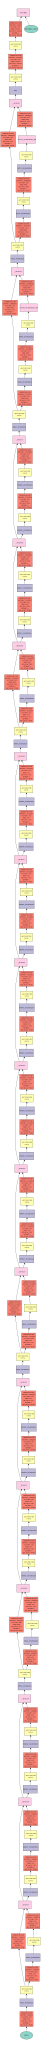

In [4]:
mx.viz.plot_network(net)